In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

## Loading in base data

In [7]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

Number of stars in selected sample: 124731


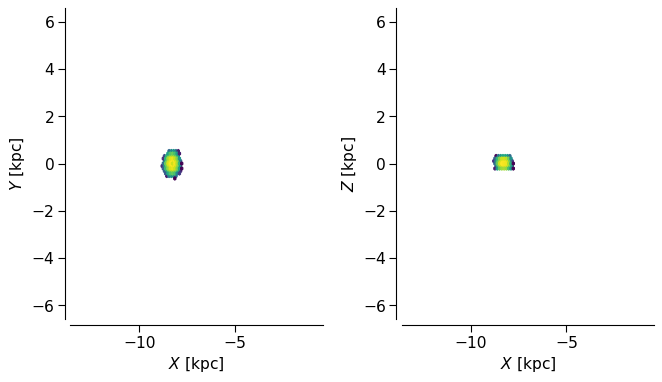

In [29]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars
spt_lum_filter = mstars
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/mstars')

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -2.4
RSE d*sin(b): 126.5
Mean d*sin(b): -2.1


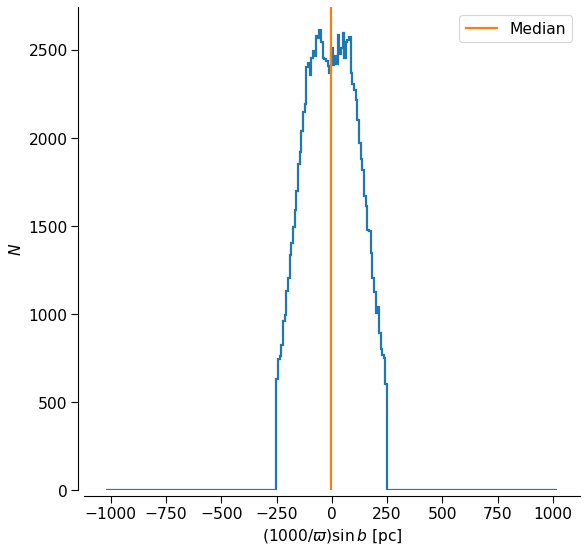

In [30]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [31]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    

base_bp_model = {'stanfile':'rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

# Old model    
declining_vcirc_disptens_model = {'stanfile':'mwdisk-declining-vcirc-disptens-model.stan', 
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
              }
# Old model
declining_vcirc_disptens_rsunfree_model = {'stanfile':'mwdisk-declining-vcirc-disptens-rsunfree-model.stan', 
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
              }

# Added wrong model: not used (Rsunfree) (is nu geen model file voor)
declining_vcirc_bp_rsunfree_model = {'stanfile':'xxxxxxxxxxxxxxxxxxxxxxxx',
               'npars':8,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Rsun', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$R_\odot$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Rsun':8.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Rsun':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}
                }                     

# Added wrong model
declining_vcirc_bp_model = {'stanfile':'rotcurve-bp_old.stan',
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}                                     
              }

test = {'stanfile':'test.stan',
               'npars':7,
               'parnames':['Vcirc_sun', 'dVcirc_dVr', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
               'labels':[r'$V_{\mathrm{circ},\odot}$', r'$dV_\mathrm{circ}/dV_R$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'], 
               'inits':{'Vcirc_sun':220.0, 'dVcirc_dVr':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
               'best_params':{'Vcirc_sun':np.nan, 'dVcirc_dVr':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan,
                              'vdispxy':np.nan, 'vdispz':np.nan}                                     
              }

stan_model = base_bp_model

distsunfree = False
if (stan_model['stanfile'] == 'mwdisk-declining-vcirc-disptens-rsunfree-model.stan'): # or declining_vcirc_bp_rsunfree_model
    distsunfree = True

Number of sources in sample: 3000


In [32]:
print(os.getenv('HOME', "not found")) # Prints "not found"

fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
#set_cmdstan_path(os.path.join(os.getenv('HOME'), 'cmdstan')) # Does not work on windows
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0')) # Needs to be replaced with cmdstan location on other Windows devices
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500    
nsampling = 1000 # Deze kan omhoog als hij nog niet convergeerd, maar dat wel gaat doen. Hoger dan convergeerwaarde heeft geen zin.
nchains = 4      

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fgkm_fit = fgkm_model.sample(show_console=False, chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook', output_dir=fit_save_location)
#fgkm_fit = fgkm_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=fgkm_data_path, save_warmup=False, show_progress='notebook')

not found


01:20:00 - cmdstanpy - INFO - compiling stan file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\rotcurve-bp2_1.stan to exe file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\rotcurve-bp2_1.exe
01:20:36 - cmdstanpy - INFO - compiled model executable: C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\rotcurve-bp2_1.exe
01:20:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:29:37 - cmdstanpy - INFO - CmdStan done processing.
01:29:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is -1.10902, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp2_1.stan', line 150, column 2 to column 55)
	Exception: rotcurve_bp2_1_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = -0.0016455, but dcov[2,1] = -317460 (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp2_1.stan', line 121, column 2 to column 30)
	Exception: rotcurve_bp2_1_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = 3.43001e+006, but dcov[2,1] = 0.000809564 (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp2_1.stan', line 121, column 2 to column 30)
	Exception: rotcurve_bp2_1_model_namespace::log_prob: dcov is not symmetric. dcov[1,2] = -19679.6, but dcov[2,1] = -0.000499255 (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/rotcurve-bp2_1.stan', lin

01:29:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


In [33]:
import winsound
frequency = 1500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

Don't forget to erase older .csv and .txt files from the fitfiles folder, when loading the new models.

https://www.wolframalpha.com/input?i=gamma%28alpha%3D1.1%2C+beta%3D10%29
https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample


['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz']
h_param = 0.1+0.1-0.1
p_param = -1.2+0.8-1.2
Vsun_pec_x = 8.6+0.8-0.9
Vsun_pec_y = 21.0+0.9-1.0
Vsun_pec_z = 8.2+0.6-0.6
vdispxy = 39.1+0.4-0.4
vdispz = 25.2+0.5-0.5


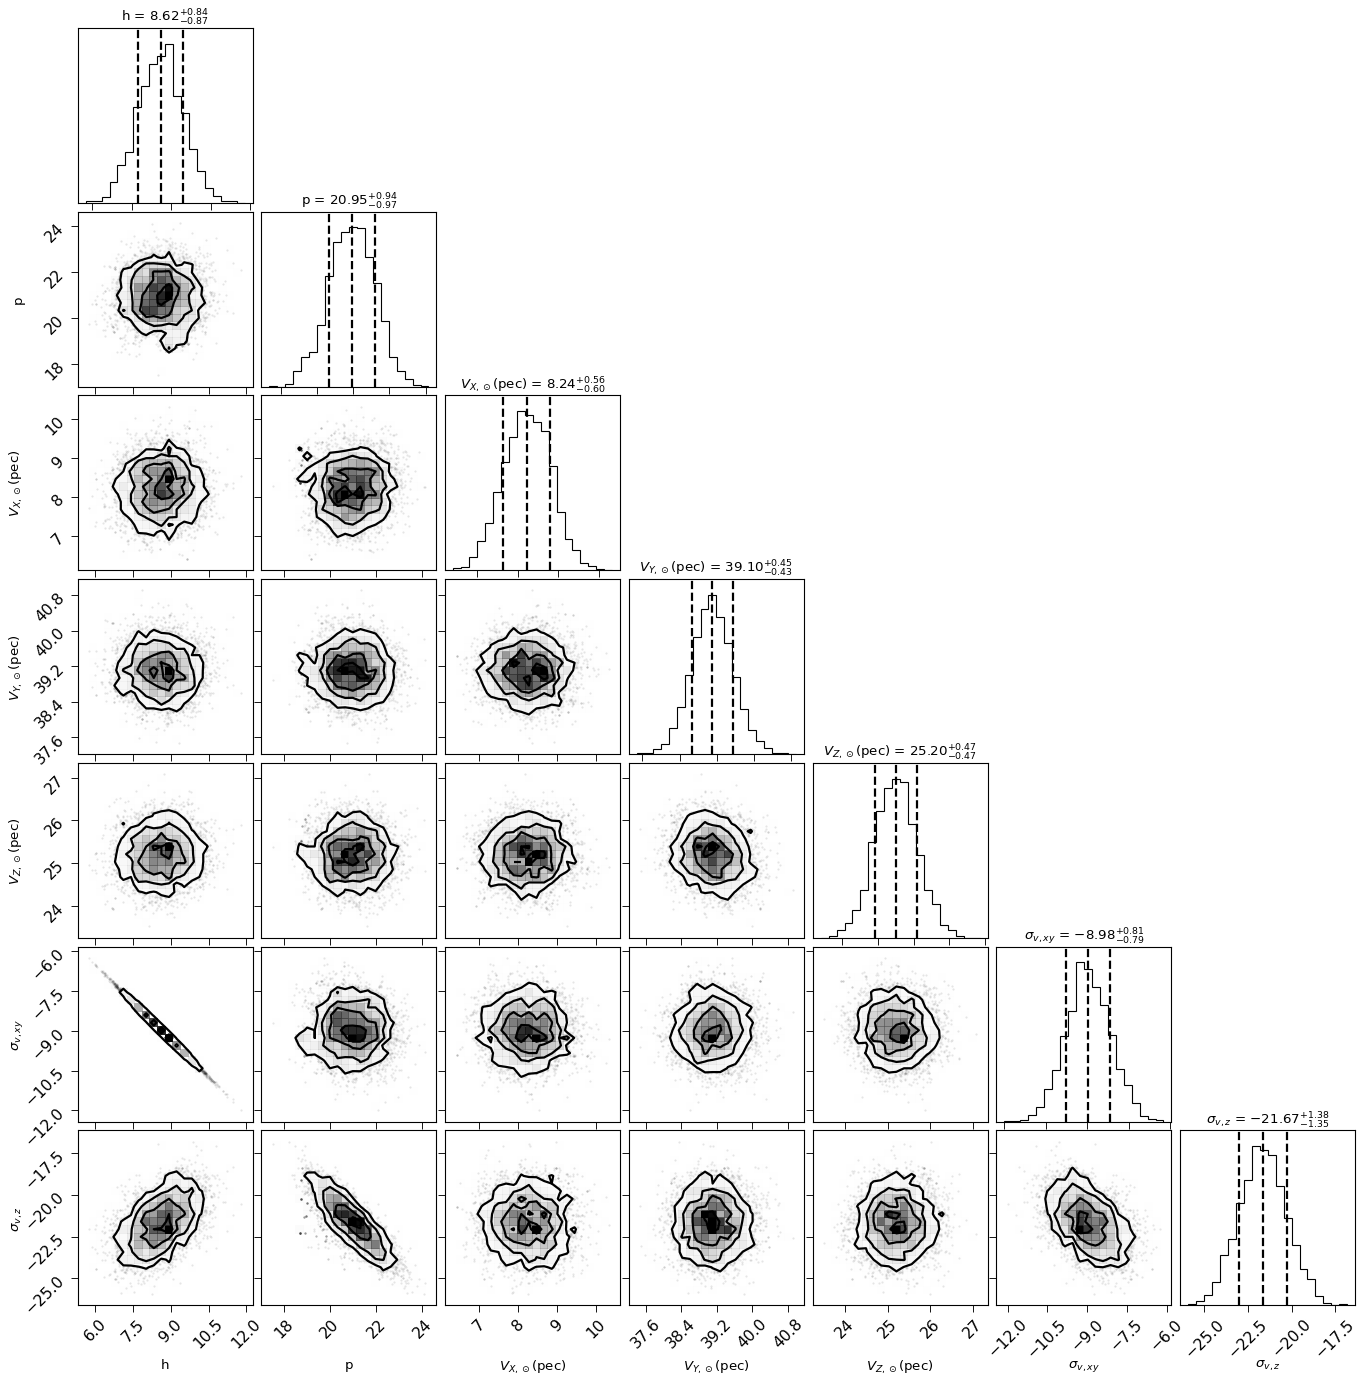

In [21]:
# For nsamples = 1000
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(9, 9+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()
# Kijken of dit zo werkt? 

['h_param', 'p_param']


h_param = 0.4+0.8-0.4
p_param = -0.3+0.5-0.1


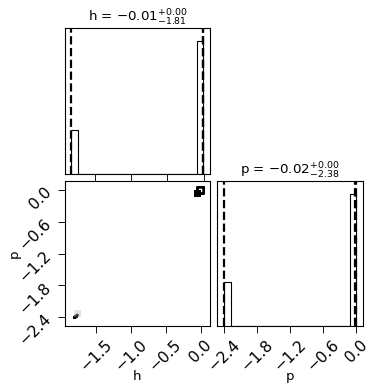

In [7]:
# For nsamples = 3000 en adapt_delta = 0.95
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(9, 9+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()
# Kijken of dit zo werkt? 

['h_param', 'p_param']
h_param = 0.1+0.3-0.1
p_param = -0.1+0.2-0.3


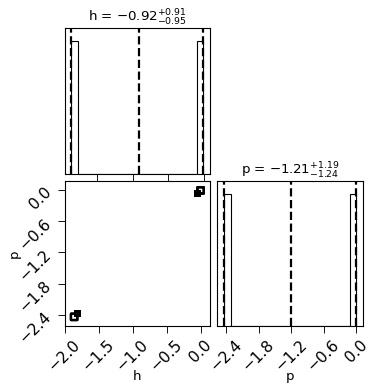

In [13]:
# For nsamples = 15000 en adapt_delta = 0.80
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(9, 9+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()
# Kijken of dit zo werkt? 